In [17]:
from time import time 

import jax.numpy as jnp
from jax import grad, value_and_grad, vmap, jit, random, lax
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from playground_jax.models import *

In [18]:
# set a random key
key = random.PRNGKey(seed=1)

In [19]:
# parameters
d = 1
dt = 0.01
K = 1000
x_init = 0 * jnp.ones((K, d))
r_lim = 1

#x_init

2. Build a model

In [20]:
# model
key, subkey = random.split(key)
model = FeedForwardNN(d_in=d, d_out=d, d_hidden=32, key=subkey)

# evaluation data
x = jnp.expand_dims(jnp.linspace(-1, 1, 101), axis=-1)
y_init = vmap(model)(x)

3. Define optimization routine 

In [21]:
lr = 1e-3
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(model)

4. Define loss

In [28]:
def cond_fn(val):
    _, _, xt, _, _ = val
    return jnp.where(jnp.linalg.norm(xt) <= 1, True, False)

def body_fn(val):
    model, step, xt, det_int, key = val
    d = xt.shape[0]
    key, subkey = random.split(key)
    dbt = jnp.sqrt(dt) * random.normal(key, (d,))
    xt = xt + dbt
    step = step + 1
    u = model(xt)
    det_int = det_int + (jnp.linalg.norm(u) ** 2) * dt
    return model, step, xt, det_int, key

def sample_fn(model, x_init, key):
    return lax.while_loop(cond_fn, body_fn, (model, 0, x_init, 0., key))
    #val = (model, 0, x_init, 0., key)
    #while cond_fn(val):
    #    val = body_fn(val)
    #return val
sample_fn = vmap(sample_fn, in_axes=(None, 0, 0), out_axes=0)

def loss_fn(model, key):
    subkeys = random.split(key, K)
    _, step, xt, det_int, key = sample_fn(model, x_init, subkeys)
    return det_int.mean(), (step, xt, key)

#loss_fn = jit(loss_fn)

5. Train

In [30]:
#sample_loss_fn(x_init[0], key)
#subkeys = random.split(key, K)
#loss, data = loss_fn(model, key)
(loss, data), grads = value_and_grad(loss_fn, has_aux=True)(model, key)
#from jax import jacfwd, jacrev
#J = jacfwd(loss_fn, has_aux=True)(model, key)

ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop with dynamic start/stop values. Try using lax.scan, or using fori_loop with static start/stop.

In [15]:
loss

Array(0.04972071, dtype=float32)

In [69]:
lr = 1e-2
steps = int(1e2)
for i in range(steps):
    t0 = time()
    (loss, data), grads = value_and_grad(loss_fn, has_aux=True)(model, x_init, key)
    model = jax.tree_util.tree_map(lambda m, g: m - lr * g, model, grads)
    t1 = time()
    if i % int(1e1) == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 4.783e-02, time: 0.3955s
it: 10, loss: 5.893e-03, time: 0.3936s
it: 20, loss: 1.450e-03, time: 0.4227s
it: 30, loss: 7.944e-04, time: 0.4013s
it: 40, loss: 5.901e-04, time: 0.5527s
it: 50, loss: 4.783e-04, time: 0.5286s
it: 60, loss: 4.063e-04, time: 0.5243s
it: 70, loss: 3.582e-04, time: 0.5232s
it: 80, loss: 3.254e-04, time: 0.5164s
it: 90, loss: 3.026e-04, time: 0.5140s


6. Evaluate

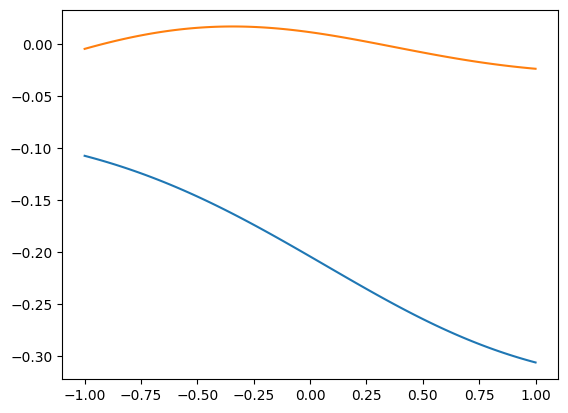

In [70]:
y_final = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y_init)
ax.plot(x, y_final)